In [45]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as st

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

In [2]:
# Import API key
from api_keys import weather_api_key

In [3]:
# Output File (CSV)
output_data_file = "output_data/cities.csv"

In [4]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [5]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

619

In [6]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "Imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [7]:
view = requests.get(query_url + "china").json()
print(view)
#print(json.dumps(view,indent=4, sort_keys=True))

{'coord': {'lon': -99.23, 'lat': 25.7}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'base': 'stations', 'main': {'temp': 98.11, 'feels_like': 97.05, 'temp_min': 98.11, 'temp_max': 98.11, 'pressure': 1010, 'humidity': 29, 'sea_level': 1010, 'grnd_level': 993}, 'wind': {'speed': 7.94, 'deg': 81}, 'clouds': {'all': 0}, 'dt': 1588708230, 'sys': {'country': 'MX', 'sunrise': 1588679816, 'sunset': 1588727407}, 'timezone': -18000, 'id': 3530839, 'name': 'China', 'cod': 200}


In [76]:
#So far I have a list of cites and an access to the api. I'm not sure if I have lat stored but i can easily collect it
#I also need Long, Temperature, Humidity, Cloudiness, and Windspeed, country, and time so i need to make empty lists for them
city_lst = []
lat_lst = []
lon_lst = []
temp_lst = []
hum_lst = []
cc_lst = []
ws_lst = []
con_lst = []
date_lst = []
count = 1

#Next I am going to loop through all the cities in my originalk list, but not all of them will have data, and will return and error
#To solve this I will make a new list of cities that only gets populated if there is data
for city in cities:
    response = requests.get(query_url + city).json()
    try:
        lat_lst.append(response['coord']['lat'])
        lon_lst.append(response['coord']['lon'])
        temp_lst.append(response['main']['temp'])
        hum_lst.append(response['main']['humidity'])
        cc_lst.append(response['clouds']['all'])
        ws_lst.append(response['wind']['speed'])
        con_lst.append(response['sys']['country']) 
        date_lst.append(response['dt']) 
        city_lst.append(city)
        print(f"{city}, #{count} of {len(cities)} has data and it has been added to the data base")
    except KeyError:
        print(f"{city}, #{count} of {len(cities)} was not found. Skipping")
    count +=1

illoqqortoormiut, #1 of 619 was not found. Skipping
barrow, #2 of 619 has data and it has been added to the data base
vaini, #3 of 619 has data and it has been added to the data base
yanam, #4 of 619 has data and it has been added to the data base
esperance, #5 of 619 has data and it has been added to the data base
qaanaaq, #6 of 619 has data and it has been added to the data base
mataura, #7 of 619 has data and it has been added to the data base
harper, #8 of 619 has data and it has been added to the data base
saint-philippe, #9 of 619 has data and it has been added to the data base
colesberg, #10 of 619 has data and it has been added to the data base
albany, #11 of 619 has data and it has been added to the data base
belushya guba, #12 of 619 was not found. Skipping
garoua, #13 of 619 has data and it has been added to the data base
akyab, #14 of 619 has data and it has been added to the data base
yabrud, #15 of 619 has data and it has been added to the data base
yellowknife, #16 of 61

arlit, #124 of 619 has data and it has been added to the data base
pisco, #125 of 619 has data and it has been added to the data base
shache, #126 of 619 has data and it has been added to the data base
zaterechnyy, #127 of 619 has data and it has been added to the data base
flinders, #128 of 619 has data and it has been added to the data base
puerto ayora, #129 of 619 has data and it has been added to the data base
wajid, #130 of 619 has data and it has been added to the data base
tura, #131 of 619 has data and it has been added to the data base
mutsamudu, #132 of 619 was not found. Skipping
chipinge, #133 of 619 has data and it has been added to the data base
sokolo, #134 of 619 has data and it has been added to the data base
namibe, #135 of 619 has data and it has been added to the data base
umm lajj, #136 of 619 has data and it has been added to the data base
erzin, #137 of 619 has data and it has been added to the data base
koumac, #138 of 619 has data and it has been added to the 

petauke, #246 of 619 has data and it has been added to the data base
luderitz, #247 of 619 has data and it has been added to the data base
okha, #248 of 619 has data and it has been added to the data base
victoria, #249 of 619 has data and it has been added to the data base
dikson, #250 of 619 has data and it has been added to the data base
khorramshahr, #251 of 619 has data and it has been added to the data base
viedma, #252 of 619 has data and it has been added to the data base
san jeronimo, #253 of 619 has data and it has been added to the data base
dombarovskiy, #254 of 619 has data and it has been added to the data base
mangla, #255 of 619 has data and it has been added to the data base
vega de alatorre, #256 of 619 has data and it has been added to the data base
hami, #257 of 619 has data and it has been added to the data base
iwanai, #258 of 619 has data and it has been added to the data base
calama, #259 of 619 has data and it has been added to the data base
aksu, #260 of 619 h

tomohon, #365 of 619 has data and it has been added to the data base
sunrise manor, #366 of 619 has data and it has been added to the data base
griffith, #367 of 619 has data and it has been added to the data base
kiunga, #368 of 619 has data and it has been added to the data base
hamilton, #369 of 619 has data and it has been added to the data base
wenling, #370 of 619 has data and it has been added to the data base
vanavara, #371 of 619 has data and it has been added to the data base
platnirovskaya, #372 of 619 has data and it has been added to the data base
ho chi minh city, #373 of 619 has data and it has been added to the data base
fort saint john, #374 of 619 was not found. Skipping
yar-sale, #375 of 619 has data and it has been added to the data base
tabiauea, #376 of 619 was not found. Skipping
cururupu, #377 of 619 has data and it has been added to the data base
sao joao da barra, #378 of 619 has data and it has been added to the data base
wellington, #379 of 619 has data and 

pahrump, #485 of 619 has data and it has been added to the data base
puerto leguizamo, #486 of 619 has data and it has been added to the data base
ginda, #487 of 619 has data and it has been added to the data base
angoche, #488 of 619 has data and it has been added to the data base
cervo, #489 of 619 has data and it has been added to the data base
weifang, #490 of 619 has data and it has been added to the data base
dukat, #491 of 619 has data and it has been added to the data base
henties bay, #492 of 619 has data and it has been added to the data base
nebyliv, #493 of 619 has data and it has been added to the data base
healesville, #494 of 619 has data and it has been added to the data base
inirida, #495 of 619 has data and it has been added to the data base
mayskiy, #496 of 619 has data and it has been added to the data base
onega, #497 of 619 has data and it has been added to the data base
rongcheng, #498 of 619 has data and it has been added to the data base
san cristobal, #499 of 

jumla, #604 of 619 has data and it has been added to the data base
barcelos, #605 of 619 has data and it has been added to the data base
lavrentiya, #606 of 619 has data and it has been added to the data base
awjilah, #607 of 619 has data and it has been added to the data base
mindelo, #608 of 619 has data and it has been added to the data base
molchanovo, #609 of 619 has data and it has been added to the data base
hailey, #610 of 619 has data and it has been added to the data base
alice town, #611 of 619 has data and it has been added to the data base
maragogi, #612 of 619 has data and it has been added to the data base
creel, #613 of 619 has data and it has been added to the data base
lagos, #614 of 619 has data and it has been added to the data base
muncar, #615 of 619 has data and it has been added to the data base
natchitoches, #616 of 619 has data and it has been added to the data base
kamaishi, #617 of 619 has data and it has been added to the data base
arkhangelsk, #618 of 619 

In [15]:
#Now That I haqve the lists I can add them to a dataframe, first I need a dictionary
weather_dict = {
    'city': city_lst,
    'lat' : lat_lst,
    'lon' : lon_lst,
    'temp': temp_lst,
    'humidity' : hum_lst,
    'cloud_cover' : cc_lst,
    'wind_speed' : ws_lst,
    'country' : con_lst,
    'date' : date_lst
}

#Then to make the dataframe
weather_data = pd.DataFrame(weather_dict)

#
weather_data.head()

,city,lat,lon,temp,humidity,cloud_cover,wind_speed,country,date
0,barrow,71.29,-156.79,14.00,78,1,11.41,US,1588714222
1,vaini,-21.20,-175.20,78.80,83,75,6.93,TO,1588714222
2,yanam,16.73,82.22,80.37,92,13,1.92,IN,1588714222
3,esperance,-33.87,121.90,57.20,58,90,33.33,AU,1588714222
4,qaanaaq,77.48,-69.36,17.91,88,98,5.57,GL,1588714192


In [17]:
weather_data.describe()

,lat,lon,temp,humidity,cloud_cover,wind_speed,date
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,5.660000e+02
mean,20.279912,18.776307,62.198799,69.906360,49.772085,8.364735,1.588714e+09
std,32.761958,90.183979,18.896526,22.352685,38.342786,6.650517,1.272606e+02
min,-54.800000,-179.170000,-2.830000,1.000000,0.000000,0.160000,1.588714e+09
25%,-6.007500,-61.372500,49.457500,57.250000,10.000000,4.000000,1.588714e+09
50%,25.425000,22.725000,63.525000,76.000000,45.500000,6.930000,1.588714e+09
75%,46.572500,99.772500,78.637500,87.000000,90.000000,10.810000,1.588714e+09
max,78.220000,179.320000,100.870000,100.000000,100.000000,61.070000,1.588715e+09


In [24]:
#I need to split the dataframe into 2 hemisphers
north_df = weather_data[weather_data['lat']>=0]
south_df = weather_data[weather_data['lat']<0]

In [73]:
#Now to make graphs I am going to create a function
def make_me_a_graph(x,y,dataframe,regress=False):
    x_axis = dataframe[x]
    y_axis = dataframe[y]
    
    fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
    ax1.scatter(x_axis,y_axis)
    ax1.set(xlabel=x,ylabel=y,title=f"{y} vs {x}")
    ax1.grid(linestyle = '-.')
    
    if regress == True:
        slope, intercept, r_value, p_value, std_err = st.linregress(x_axis,y_axis)
        nl = '\n'
        eq = f"y={round(slope,2)}*x + {round(intercept,2)}"
        ax1.plot(x_axis, slope*x_axis + intercept, color = 'r', label=f"R-value = {r_value}{nl} {eq}")
        ax1.legend(loc='best')

In [35]:
#make_me_a_graph("lat","temp",weather_data)
#The first thing i notice is there are more points the more positive the latitude, which makes sense
#More of the land mass in is the northern hemisphere. 
#Second, the temperature does appear to be latitude dependent but hits its peak around 20.
#This is probably a result of the oceanic currents along with the fact that is is spring time in the north, fall in the south

In [37]:
#make_me_a_graph("lat","humidity",weather_data)
#Humidity appears to spike downward between +/- 20-40

In [39]:
#make_me_a_graph("lat","cloud_cover",weather_data)
#There does not appear to be much of a correlation between cloudcover and latitude
#However, there are congrgations around 100, 90, 75, 40, 20, and 0. 
#This leads me to think that some fo the data collection is some person making a guestimate. 

In [41]:
#make_me_a_graph("lat","wind_speed",weather_data)
#There are a few outliers in this group that seem safe to ignore
#There is a slight correlation between higher windspeeds further from the equator. 

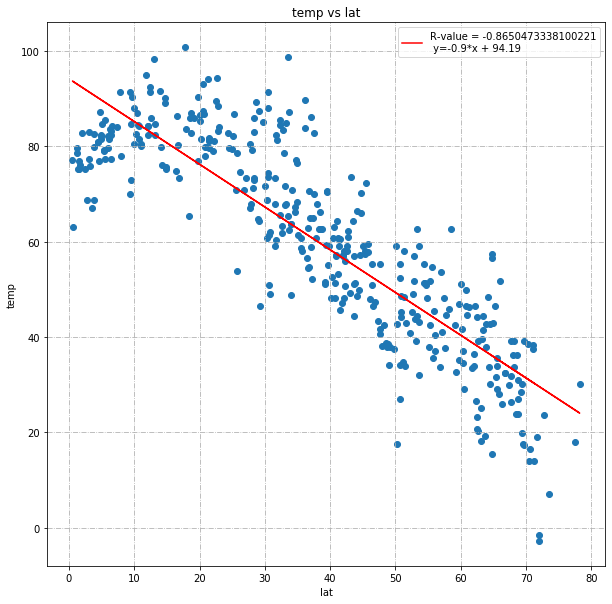

In [74]:
make_me_a_graph("lat","temp",north_df,regress=True)

In [58]:
#make_me_a_graph("lat","humidity",north_df,regress=True)

In [65]:
#make_me_a_graph("lat","cloud_cover",north_df,regress=True)

In [67]:
#make_me_a_graph("lat","wind_speed",north_df,regress=True)

In [61]:
#make_me_a_graph("lat","temp",south_df,regress=True)

In [62]:
#make_me_a_graph("lat","humidity",south_df,regress=True)

In [63]:
#make_me_a_graph("lat","cloud_cover",south_df,regress=True)

In [ ]:
#make_me_a_graph("lat","wind_speed",south_df,regress=True)